# BEAST Workflow Example

This tutorial provides an example for how to use the Bayesian Extinction and Stellar Tool (BEAST). The tutorial was generated from a Jupyter notebook, which can be downloaded [here](https://github.com/BEAST-Fitting/beast/tree/master/docs/tutorial/tutorial.ipynb). 

Before starting, please make sure you have **at least BEAST v2.0** installed. 

In [128]:
extensions = ["nbsphinx"]
import h5py

import numpy as np
import pandas as pd
from astropy import wcs
from astropy.io import fits
from astropy.table import Table

import glob
import os
import types
import argparse
import importlib
from IPython.display import Image


import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

from beast.plotting import (plot_mag_hist, 
                            plot_ast_histogram, 
                            plot_noisemodel
)

from beast.tools.run import (
    create_physicsmodel,
    make_ast_inputs,
    create_obsmodel,
    run_fitting,
    merge_files,
    create_filenames,
)

from beast.physicsmodel.grid import SEDGrid
from beast.fitting import trim_grid
import beast.observationmodel.noisemodel.generic_noisemodel as noisemodel
from beast.observationmodel.observations import Observations
    
from beast.tools import (
     beast_settings,
     create_background_density_map,
     split_ast_input_file,
     split_catalog_using_map,
     cut_catalogs,
     setup_batch_beast_trim,
)

# A Brief Introduction to the BEAST

The Bayesian Extinction and Stellar Tool (``BEAST``) is a probabilistic Python program which can be used to model the intrinsic properties of individual stars and dust along each sightline based on their multi-wavelength spectral energy distributions (SEDs). 

To characterize individual stars, the BEAST compares the observed SED of star with predicted/model SEDs. Model SEDs are constructed by generating a grid of stellar spectra across a range of initial masses, ages, and metallicities. Then, varying amounts of extinction are applied to each stellar spectrum based on the dust extinction models (defined by three dust parameters: Av, Rv, and fA which modifies the extinction curve), producing an even larger grid of extinguished spectra. The grid is then duplicated at a range of distances (if relevant), creating a seven-dimensional parameter grid of extinguished stellar spectra. We then integrate these spectra over telescope transmission curves for each observed filter to generate model photometric measurements (i.e. simulated SEDs) for every combination of input stellar and dust parameters. 

Lastly, to account for systemic observational effects in the actual photometry, we use artificial star tests to quantify the average photometric bias as a function of flux in each filter. These biases are added to the predicted SEDs so we can accurately compare with the observed SEDs, since the uncertainty of most photometric measurements will be smaller than the uncertainty of our models.


## Step 0. Data Setup


For this example, we will be walking through a standard BEAST workflow example using photometry from the [Panchromatic Hubble Andromeda Treasury (PHAT)](https://archive.stsci.edu/hlsp/phat) survey. 

If you are running this example notebook locally, the example data can be fetched [here](https://www.dropbox.com/sh/91aefrp9gzdc9z0/AAC9Gc4KIRIB520g6a0uLLama?dl=0)

Download the files manually from the link above and place them in a folder called `/data` within the same folder as this notebook.

> **Note:** Sometimes photometric catalogs are delivered as ``HDF5`` files. While these are great for storing data in heirarchies, it's a little hard to work with directly, so we have to convert our ``HDF5`` file to a ``FITS`` file. Thankfully, our photometric catalog for this example is already in a ``FITS`` format so we don't need to worry about this and can move straight on to Step 1.

## Step 1a. Make magnitude histograms

The first thing we need to do is understand the range of stellar magnitudes we are working with in this data set.

To do this, we can make histograms of all the magnitudes of all the stars in all the different filters from the photometric catalog. This is done so that we know where the peaks of the histograms are in each filter. These peaks will then be used later when we make source density maps.

Essentially what happens is that, for the density maps, we only count objects within a certain range, currently set to mag_cut = 15 - (peak_for_filter-0.5). So if the peak was 17.5, then the objects that would be counted would have to be in the range between 15 and 18.

The reason we only count brighter sources is because dimmer sources tend to not be properly observed, especially as the magnitudes near the telescope limit. There will always be far more dim sources than bright sources, but if we know how many bright sources there are, then we can extrapolate as to how many dim sources there should be, and probably get a better understand from that than if we were to try and actually count all the dim sources we detect.

**Variable Information**

- ``field_name`` : the string name of the main photometric catalog we are working with. This variable will be used to rename a lot of different files in the future which is why we have it as a separate variable.
- ``gst_file`` : stands for good-stars, this is the full name for the original photometric catalog we are working with.

  Note: ``st`` stands for stars. We also sometimes name things ``gst`` for good stars to signify when cuts have been made.

In [2]:
field_name = "M31-B09" # this is a portion of the M31 Brick09 
gst_file = "./data/%s.st.fits" %field_name

We can see what type of data this fits file holds by making a table. There should be around 50,000 sources in this calalog, which is quite small compared to the original file.



In [3]:
hdul = fits.open(gst_file)
Table(hdul[1].data)

F814W_ST,F814W_GST,F475W_ST,F475W_GST,F275W_ST,F275W_GST,F160W_ST,F160W_GST,F336W_ST,F336W_GST,F110W_ST,F110W_GST,X,Y,RA,DEC,CHI_GL,SNR_GL,SHARP_GL,ROUND_GL,CROWD_GL,F475W_COUNT,F475W_SKY,F475W_RATE,F475W_RATERR,F475W_VEGA,F475W_TRANS,F475W_ERR,F475W_CHI,F475W_SNR,F475W_SHARP,F475W_ROUND,F475W_CROWD,F814W_COUNT,F814W_SKY,F814W_RATE,F814W_RATERR,F814W_VEGA,F814W_TRANS,F814W_ERR,F814W_CHI,F814W_SNR,F814W_SHARP,F814W_ROUND,F814W_CROWD,F275W_COUNT,F275W_SKY,F275W_RATE,F275W_RATERR,F275W_VEGA,F275W_TRANS,F275W_ERR,F275W_CHI,F275W_SNR,F275W_SHARP,F275W_ROUND,F275W_CROWD,F336W_COUNT,F336W_SKY,F336W_RATE,F336W_RATERR,F336W_VEGA,F336W_TRANS,F336W_ERR,F336W_CHI,F336W_SNR,F336W_SHARP,F336W_ROUND,F336W_CROWD,F110W_COUNT,F110W_SKY,F110W_RATE,F110W_RATERR,F110W_VEGA,F110W_TRANS,F110W_ERR,F110W_CHI,F110W_SNR,F110W_SHARP,F110W_ROUND,F110W_CROWD,F160W_COUNT,F160W_SKY,F160W_RATE,F160W_RATERR,F160W_VEGA,F160W_TRANS,F160W_ERR,F160W_CHI,F160W_SNR,F160W_SHARP,F160W_ROUND,F160W_CROWD,EXT,CHIP,MAJAX_GL,OBJTYPE_GL,F475W_FLAG,F814W_FLAG,F275W_FLAG,F336W_FLAG,F110W_FLAG,F160W_FLAG
bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
True,True,True,True,True,True,True,True,True,True,True,True,869.8900000046692,44.40999999483233,11.131832570656686,41.603419438518735,4.03,2917.0,-0.03,0.02,0.251,233000000.0,87358.19,9.039999999999999e-08,1.3800000000000002e-09,17.61,17.721,0.017,2.48,65.4,0.005,0.038,0.175,198000000.0,102360.6,1.59e-07,1.27e-09,16.996,16.986,0.009000000000000001,1.77,124.8,0.01,0.049,0.22699999999999998,5970000.0,2256.98,1.25e-07,1.16e-09,17.255,nan,0.01,2.92,107.7,-0.038,0.018000000000000002,0.086,23800000.0,7534.45,1.69e-07,6.92e-10,16.932000000000002,nan,0.004,2.63,243.9,-0.031,0.059000000000000004,0.084,79700000.0,88039.23,1.6e-07,2.58e-10,16.992,nan,0.002,2.23,619.1,-0.004,0.1,0.35,56000000.0,93657.59,1.8e-07,2.53e-10,16.864,nan,0.002,1.51,708.8,-0.018000000000000002,0.027000000000000003,0.396,0,1,165,1,2,2,0,0,0,0
True,True,True,True,True,True,True,True,True,True,True,True,868.3900000040028,42.189999993549804,11.13180414033402,41.60338891056161,4.13,2566.5,-0.05,0.028999999999999998,0.27699999999999997,125000000.0,46004.84,4.85e-08,2.51e-10,18.285999999999998,18.412,0.006,3.02,193.3,-0.053,-0.006,0.231,118000000.0,77080.48,9.23e-08,1.24e-09,17.587,17.577,0.015,5.87,74.3,-0.096,0.044000000000000004,0.324,4360000.0,2332.74,9.15e-08,7.099999999999999e-10,17.597,nan,0.008,2.08,128.8,-0.057,0.008,0.092,16500000.0,8339.99,1.1699999999999999e-07,9.25e-10,17.329,nan,0.009000000000000001,3.74,126.5,-0.085,-0.006999999999999999,0.106,49500000.0,82165.18,9.92e-08,2.82e-10,17.508,nan,0.003,2.79,352.5,0.013000000000000001,-0.079,0.516,35100000.0,87515.55,1.13e-07,3.31e-10,17.371,nan,0.003,2.18,340.0,-0.026000000000000002,-0.004,0.635,0,1,75,1,2,2,0,2,0,0
True,True,False,False,False,False,True,True,False,False,True,True,297.1500000049341,22.169999994536283,11.135275566985227,41.595888643103535,1.17,1663.1,-0.08800000000000001,0.061,0.008,29910.7,10270.95,1.1499999999999999e-11,1.34e-12,27.348000000000003,27.805999999999997,0.126,1.34,8.6,-0.634,0.177,0.025,4160000.0,21190.25,3.17e-09,1.0000000000000001e-11,21.248,21.423000000000002,0.003,0.9,316.3,-0.063,0.049,0.001,-1.7,44.5,-6.900000000000001e-14,1.49e-11,nan,nan,9.999,0.87,-0.0,1.058,2.951,0.0

As we can see, there's a lot of columns describing the photometry. For plotting the magnitude histograms, we're going to be interested in any column that contains the name ``VEGA``. For this example data, there are six filters and these are the columns with the magnitudes for each filter.

We could also use the ``X`` and ``Y`` columns to plot where are the sources are located, or the ``RA`` and ``DEC`` to map their actual position in the sky.

In larger projects we might have multiple fields to analyze during each run, so there would be multiple ``field_names``. Since this is just a small example, we just have one field so our index will always be equal to ``0``.

In [4]:
# the list of fields (we only have 1 for this example.)
field_names = [field_name]

Now we can create some histogram plots to visualize the magnitude distribution of our sources.



In [5]:
# this 'if' statement just checks if there's already a histogram file
image_file = './data/'+field_names[0]+'.st_maghist.pdf'
peak_mags = plot_mag_hist.plot_mag_hist(gst_file, stars_per_bin=70, max_bins=75)

You can check out the results for the histograms in the file ending with ``_maghist.pdf``. They should look something like this:

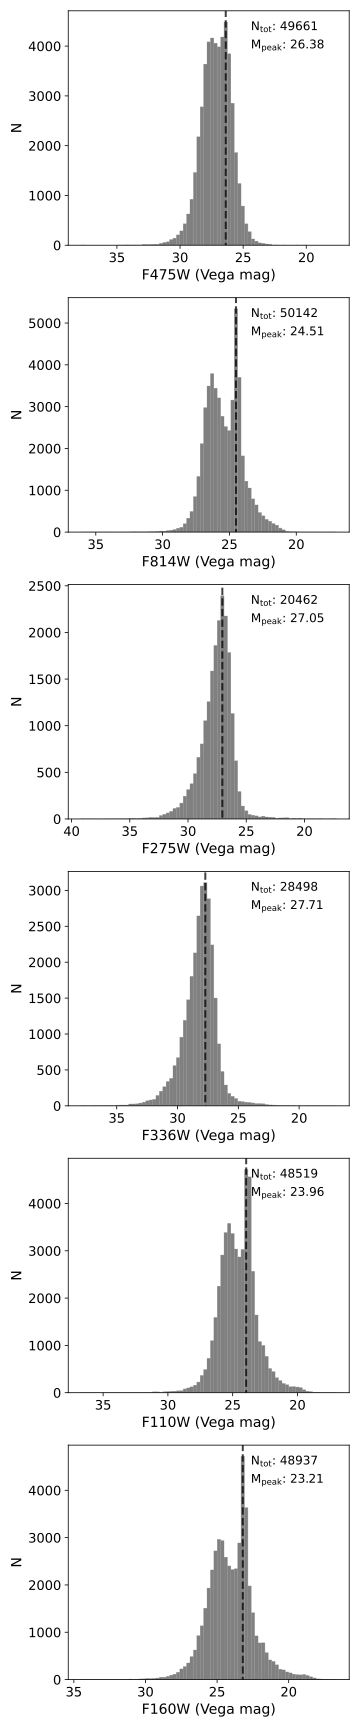

From this plot, we can see that the sources in our field was observed in six different filters, and that the majority of sources are roughly between 20-30 mag in brightness depending on the filter.



## Step 1b. Make source density maps

Next we'll be creating source density maps. These are maps of our data segmented to capture variability in the stellar density across the field. This is important to capture, especially in dense galaxies because the level of crowding will impact the number of individual stars that can be measured, and their uncertainties. 

> **Note:** The standard source density pixel size is 5 arcsec squared. 

If working with a smaller subset of data (or a sparser galaxy), gridding to 5 arcsec squared could run the risk of not having enough stars in each source density bin later on when we calculate the noisemodel. To avoid this, set your pixel size to be larger, e.g. 15 arsec, which gives you fewer source density bins but more stars in each source density bin. The size can easily be changed by modifying the `pixsize` variable below.

In [6]:
# Pick the filter with the dimmest peak from the histogram
ref_filter =["F475W"]

# choose a filter to use for removing artifacts
# (remove catalog sources with filter_FLAG > 99)
flag_filter = ["F475W"]

In [7]:
# pixel size of 5 arcsec
# use ref_filter[b] between vega mags of 15 and peak_mags[ref_filter[b]]-0.5
# since we're only working with one field, our index b is set to 0
sourceden_args = types.SimpleNamespace(
    subcommand="sourceden",
    catfile=gst_file,
    pixsize=5,
    npix=None,
    mag_name=ref_filter[0]+ "_VEGA",
    mag_cut=[17, peak_mags[ref_filter[0]] - 0.5],
    flag_name=flag_filter[0]+'_FLAG',
    diffSpike=None,
    erode_boundary=None
)

create_background_density_map.main_make_map(sourceden_args)

# of x & y pixels =  12 12
working on converting ra, dec to pix x,y


In [8]:
# new file name with the source density column
gst_file_sd = gst_file.replace(".fits", "_with_sourceden.fits")

This function should create 3 files:

1. ``M31-B09.st_source_den_image.fits``: a file for with the source density information which can be viewed in ``ds9`` or with ``matplotlib``

2. ``M31-B09.st_sourceden_map.hd5``: the same file as ``source_den_image`` but now with the source density information for each source included (the ``split_catalog_using_map`` function used later will assume this name format)

3. ``M31-B09.st_with_sourceden.fits``: the same as the original photometric file (``gst_file``) but now with an additional column for what density bin the source is located in

### View the fits images of the source density maps
Now that we have the source density maps outputted, we can plot the image and see that the density looks like.

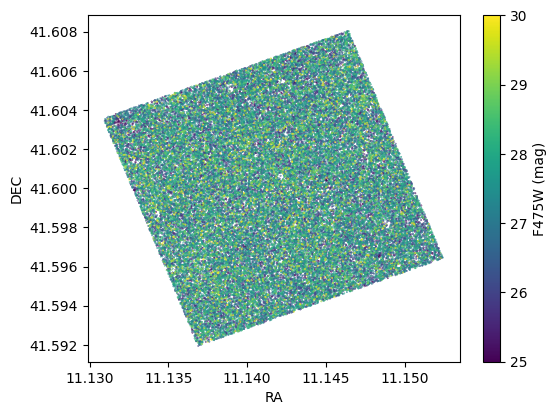

In [9]:
stats = Table.read(gst_file)

fig, ax = plt.subplots(1,1, figsize=(6, 4.5))

cbar = ax.scatter(stats["RA"], stats["DEC"], s=0.1, c=stats["F475W_VEGA"], vmin=25, vmax=30)
ax.set_xlabel("RA")
ax.set_ylabel("DEC")
plt.colorbar(cbar, label="F475W (mag)")
plt.show()

Filename: ./data/M31-B09.st_source_den_image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      20   (12, 12)   float64   


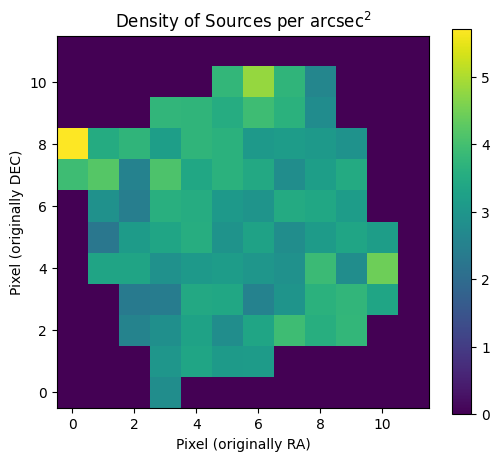

In [10]:
# open the fits file
hdu_list = fits.open("./data/%s.st_source_den_image.fits"%field_name)
hdu_list.info()

# extract the image data
image_data = hdu_list[0].data

# close the fits file
hdu_list.close()

# plot the extracted image data
fig = plt.figure(0, [6, 5])
im = plt.imshow(image_data, origin="lower")
plt.colorbar(im)
plt.xlabel("Pixel (originally RA)")
plt.ylabel("Pixel (originally DEC)")
plt.title("Density of Sources per arcsec$^2$")
plt.show()

## Step 1c. Set up beast_settings.txt file

At this point, we have a basic understanding of the information we are working with, so it's about time we set up our ``beast_settings.txt`` file. 

The ``beast_settings`` file is a sort of catch-all file used to store any sort of infomation we might need to run the BEAST code on our data. We'll go through and talk about what all the different variables mean, and which ones would need to be changed for any future projects.

Variables labeled AC (either here or in ``beast_settings.txt``) are where the user's input change is NOT necessary/recommended

For convenience, we state the path here, as we'll be updating and reloading this file a few times throughout.

In [11]:
settings_path = "./data/beast_settings.txt"
settings = beast_settings.beast_settings(settings_path)

MESA/MIST isochrones
Working on the MIST isochrone


Go ahead and open the beast_settings.txt file in a text editor now and ensure that the following variables match:

*  **project** : the same as the field_name variable we noted earlier
    * `project = "M31-B09" `
    
    
* **surveyname** : the overall name for the survey (this variable isn't actually important for the code)
    * `surveyname = "PHAT-M31"`
    
    
* **filters** : the full filter names from the photometric catalog, also the names that show up in our magnitude histograms so you can add them from there
    * `filters = ["HST_WFC3_F275W", "HST_WFC3_F336W","HST_WFC3_F475W", "HST_WFC3_F814W", "HST_WFC3_F110W", "HST_WFC3_F160W",]`
    
    
* **base filters** : shortened versions of the filter names
    * `basefilters = ["F275W", "F336W", "F475W", "F814W", "F110W", "F160W"]`
    
    
* **obsfile** : the name of the photometric catalog
    * `obsfile = "./data/" + project + ".gst.fits"`
    
    
* **noisefile** : absflux calibration covariance matrix for HST specific filters (AC)
    * `noisefile = "./data/" + project + "_noisemodel.hd5"`
    
    
* **absflux_a_matrix** : absflux calibration covariance matrix for HST specific filters (AC)
    * `absflux_a_matrix = absflux_covmat.hst_frac_matrix(filters)`
    
    
    

There will be the following parameters common to all methods of AST generation:


* **ast_with_positions** : make sure is set to *True* if you have the locations included in your obsfile
    * `ast_with_positions = True`
    
    
* **ast_realization_per_model** : number of realizations of each included AST model to be put into the list; the default (20) is necessary for truncheon noise model, but one realization is sufficient for the toothpick noise model.
    * `ast_realization_per_model = 1`


* **ast_density_table** : the source density map created in step 1b  
    * `ast_density_table = '"./M31-B09.st_sourceden_map.hd5"`
    
    
* **ast_pixel_distribution** : (used if ast_with_positions is True), minimum pixel separation between AST position and catalog star used to determine the AST spatial distribution  
    * `ast_pixel_distribution = 10.0`
    
    
* **ast_reference_image** : the original photometric FITS catalog which is required if you use the ast_with_positions as true  
    * `ast_reference_image = "M31-B09_F475W_drz.chip1.fits"`
    
    
* **astfile** : the file of ASTs we will be creating in step 3, but since ASTs normally have to be processed by a specialist, we have already included a finished AST file for us to use in this example
    * `astfile = "./M31-B09.gst.fake.fits"`
    
    
* **ast_colnames** : names of columns for filters in the AST catalog (AC)
    * `ast_colnames = np.array(basefilters)`
    
    
* **n_subgrid** : the number of subgrids to use for generating the physics model later on (with 1 meaning no subgrids);
    * `n_subgrid = 1`
    
    
    

 

For the recommended manner of AST generation, which is by source density binning, there are also the following options to set:

* **sd_binmode** : whether to use linear or logarithmic source density binning
    * `sd_binmode = "log"`
    
    
* **sd_Nbins** : number of bins in source density to use
    * `sd_Nbins = "4"`
    
    
* **sd_binwidth** : width of soruce density bins; only used for linear spacing
    * `sd_binwidth = None`
    
    
* **sd_custom** : width of soruce density bins; only used for linear spacing
    * `sd_custom = None`
    
    
* **ast_n_flux_bins** : number of flux bins into which the dynamic range of the model grid in each filter is divided (if pick_models_toothpick_style is used)
    * `ast_n_flux_bins = 100`
    
    
* **ast_n_per_flux_bin** : minimum number of model SEDs that need to fall into each bin (if pick_models_toothpick_style is used)
    * `ast_n_per_flux_bin = 50`  
    
    
* **ast_bands_above_maglimit** : number of filters that must be above the magnitude limit for an AST to be included in the list
    * `ast_bands_above_maglimit = 3`  
    
    
* **ast_models_selected_per_age** : number of models to pick per age
    * `ast_models_selected_per_age = 100`
    
    
    
    

This file is also where you specify the parameters and resolution of your physics model which will become relevant in step 2. The resolution of these parameters for your own runs will differ depending on what sorts of ASTs you want to model. There are 8 parameters that can be set.

1. **Distance** : either a fixed value or a range with stepsizes
2. **Velocity** : what is the heliocentric velocity of your location or galaxy in km/s
3. **Age** : the log10 age range of the ASTs being modeled
4. **Mass** : the mass of the ASTs
5. **Metallicity** : the metallicity range of the ASTs

6. **A(v)** : the range of dust extinction in magnitudes that could be dimming the intrinsic brightness of the ASTs
7. **R(v)** : the range of dust grain sizes 
8. **f(A)** the mixture factor between the Milky Way and Small Magellanic Cloud extinction curves

Our goal after this would normally be to eventually run a bunch of **ASTs** (Artificial Star Tests), but before we can do that, we need to generate the fake stars to use.

Since the ASTs would normally need to be analyzed by a specialist after being created and that's a little overkill for a small example, these next couple of steps are just to illustrate how the ASTs are actually generated. A finished file of the analyzed ASTs already exists so we will end up using that in step 4 and beyond.



# Step 2. Create Stellar SED Model Grid (Physics Model)

In order to generate a diverse and representative sample of fake stars to use for our ASTs, we need to set up a N-dimensional model of possible stellar parameters, so that we can easily and randomly select stars from the model.

This model is called a **physics model**, and we will be using the parameters set in the beast_settings.txt file to create this N-dimensional grid.

> **Note:** the resolution on the stellar parameters (the step size, often specified as the third input e.g. logt = [6.0, 10.13, 1.0], where 1.0 is the step size) is the main factor driving how long this physics grid will take to set up. If things take a very long time to run, consider making the step size larger for testing's sake.

<!-- Sometimes we are able to have access to high-performance computing resources, meaning we can split the physics model into subgrids and run them in parallel, cutting a lot of the computation time. While we're like not running this notebook in parallel here, we've still specified a number of subgrids in the ``beast_settings.txt`` file. 

We can check how many subgrids are set up. -->


In [12]:
# directly create physics model grids
create_physicsmodel.create_physicsmodel(beast_settings_info=settings_path, nprocs=1, nsubs=settings.n_subgrid)

MESA/MIST isochrones
Working on the MIST isochrone
generating a linear av grid


In [13]:
model_grid_file = glob.glob("./{0}/{0}_seds.grid.hd5".format(field_names[0]))

Hopefully a spectral grid and an SED grid should have started generating. In the end you should have a new folder with the same name as your project `\M31-B09`. In it should be various files.

# Step 3. Create Input ASTs (Broken)

Now that we have our physics model generated, we can start to generate some input ASTs. ASTs are artificial sources inserted into the observations we have, which are then extracted with the same software that was used for the original photometry catalog. So the step that we're running now is just generating the artifical sources that will then later be inserted. 

<!-- We need to make sure that the ASTs cover the same range of magnitudes as our original photometric catalog does, so to do that -->


There are three main types of ways to populate ASTs:
1. Splinter = Fractional uncertainties
2. Toothpick = 1D uncertainties
3. Truncheon = Full covariance models

In [147]:
# this step can take a bit
# make_ast_inputs.make_ast_inputs(settings, pick_method="flux_bin_method")

In [148]:
# ast_input_file = ("./{0}/{0}_inputAST.txt".format(field_names[0]))
# ast = Table.read(ast_input_file, format="ascii")
# ast

### Check to see how the SEDs and the ASTs compare

The histogram that is produced should have both the SED distribution and the AST distribution plotted on it. The thing we want to test for is whether the AST distribution fully samples the SED range.

In [ ]:
plot_ast_histogram.plot_ast_histogram(ast_input_file, sed_grid_file=model_grid_files[0])

# Step 4. Edit/Split the Catalog

We have to remove sources from the input photometry catalog that are in regions without full imaging coverage or flagged as bad in flag_filter. This step should mostly just be removing any sources where one of the filters might not have a value.

In [14]:
gst_file_cut = gst_file.replace(".fits", "_with_sourceden_cut.fits")

# check to see if the trimmed catalog already exists
if not os.path.isfile(gst_file_cut):
    # and if not
    cut_catalogs.cut_catalogs(
        gst_file_sd,
        gst_file_cut,
        partial_overlap=True,
        flagged=True,
        flag_filter=flag_filter[0],
        region_file=True,
    )

removing 177 stars from ./data/M31-B09.st_with_sourceden.fits


The photometry file should have CUT_FLAG column. For each star, the value must be either 1 or 0 (being 1 if the source is cut)

The CUT_FLAG column should be set for 1 for any regions from which stars need not be modelled (ie, contamination, diffraction spikes, etc).

In [15]:
gst_cut = Table.read(gst_file_cut)
gst_cut['CUT_FLAG'] = np.zeros(len(gst_cut)).astype(int)
gst_cut['CUT_FLAG'][np.where(gst_cut[flag_filter[0]+'_FLAG'] == 99)] = 1
gst_cut.write(gst_file_cut, overwrite=True)

After making these cuts, we should now update the `obsfile` name in beast_settings.txt with this new trimmed filename: `"*.gst_with_sourceden_cut.fits"`

In [16]:
settings.obsfile = "./data/M31-B09.st_with_sourceden_cut.fits"
print(settings.obsfile)

./data/M31-B09.st_with_sourceden_cut.fits


# Step 5. Edit/Split the ASTs

Now for this step, we're doing things a little unconventionally since actually placing all the input ASTs we generated in Step 3 back into our image and rerunning the analysis would take several days of computational time. 

Instead, we already have a good AST results file (produiced by Ben Williams from UWash) which we can use to complete our analysis. The AST file should be named `./data/M31-B09-EAST_chunk.gst.fake.fits` while the input ASTs we generated were named *`./M31-B09-EAST_chunk/M31-B09-EAST_chunk_inputAST.txt`*.

We will now use the same cutting procedure as for the catalog to trim down the AST file with the same criteria as in Step 4.

In [17]:
ast_file = "./data/" + field_names[0] + ".gst.fake.fits"
ast_file 

'./data/M31-B09.gst.fake.fits'

In [19]:
ast_file_cut = ast_file.replace(".fits", "_cut.fits")

# check to see if the trimmed AST file already exists
if not os.path.isfile(ast_file_cut):    
    
    # if not, generate cut AST file
    cut_catalogs.cut_catalogs(
        ast_file,
        ast_file_cut,
        partial_overlap=True,
        flagged=True,
        flag_filter=flag_filter[0],
        region_file=True,
    )

removing 31841 stars from ./data/M31-B09.gst.fake.fits


We can plot the AST magnitudes against our original source magnitudes again, just to check that we are within a reasonable range.

In [20]:
plot_mag_hist.plot_mag_hist(ast_file_cut, stars_per_bin=200, max_bins=30)
# and so this should plot a histogram of the different asts that remain after cutting  

./data/M31-B09.gst.fake_cut.fits


The AST files need to have a CUT_FLAG column. For each artificial star, the value must be either 1 or 0 (being 1 if the source is cut)

The CUT_FLAG column should be set for 1 for any regions from which real stars need not be modelled

In [21]:
ast_cut = Table.read(ast_file_cut)
ast_cut['CUT_FLAG'] = np.zeros(len(ast_cut)).astype(int)
ast_cut['CUT_FLAG'][np.where(ast_cut[flag_filter[0]+'_FLAG'] == 99)] = 1
ast_cut.write(ast_file_cut, overwrite=True)

Same with these cuts, we now have to update the `astfile` variable in beast_settings.txt with this new trimmed filename: `.gst.fake_cut.fits`

In [22]:
settings.astfile = ast_file_cut
print(settings.astfile)

./data/M31-B09.gst.fake_cut.fits


# Step 6. Split catalog by source density

For the next fitting step, we're going to have to break our catalog and AST file into bins based on the source density, and then further into sub-bins if there are more than ~6250 sources in the bins. 

We split things into source density bins so that we can later study how the actual source density of region effects the noise or bias. We further split things into sub-bins, just to make things a little more computationally accessible.

One thing to note is that the source density bins are first sorted by magnitude (typically F475W if it's there) before being split into sub-bins. This means that the first sub-bin file (for a source density bin that has more than 6250 sources) will end up having all the dimmest sources or any sources with NAN values, and the last sub file will have all the brightest sources. This will become handy in Step 8 when we create physics (SED) models and noisemoels tailored specifically to each sub-bin file.

In [23]:
split_catalog_using_map.split_main(
        settings_path,
        gst_file_cut,
        ast_file_cut,
        gst_file.replace('.fits','_sourceden_map.hd5'), #get full sourceden_mad.hd5 file from dust folder
        #bin_width=1,
        n_per_file=6250, #this is the max number of sources per bin before it splits 

    )
# print(glob.glob(gst_file_cut.replace('.fits','*sub*fits') ))

MESA/MIST isochrones
Working on the MIST isochrone
bin edges:  [2.24649876 2.84253002 3.59669769 4.55095784 5.75839814]
Splitting catalog
bin 0: 2592 sources
dividing into 1 subfiles for later fitting speed
bin 1: 8797 sources
dividing into 2 subfiles for later fitting speed
bin 2: 26440 sources
dividing into 5 subfiles for later fitting speed
bin 3: 11600 sources
dividing into 2 subfiles for later fitting speed
bin 4: 901 sources
dividing into 1 subfiles for later fitting speed

Splitting ASTs
bin 0: 976 sources
bin 1: 3488 sources
bin 2: 10365 sources
bin 3: 4502 sources
bin 4: 377 sources


So these are all the different source density bins, with some of them being split into sub bins to limit the number of entries to ~6250. 

When working with subgrids, a lot of files get made above. So, rather than reading in all the files we just created, the BEAST developers have written a handy little function that generates a dictionary of all the files that have just been created (assuming the function ran correctly) and all the files that we hope to generate in the future.

Because of this, I recommend not changing any of the naming for Step 6 or beyond, just because that then makes this dictionary point to incorrect files.

In [24]:
file_dict = create_filenames.create_filenames(
    settings,
    use_sd=True, 
    nsubs=settings.n_subgrid)

If we take a look in our folder, we should be able to see some bins with sub-bins notation. We can do a quick check to see if the sub-binning generated from the dictionary matchs up with the files split in our data folder.

In [25]:
sd_sub_info = file_dict["sd_sub_info"]
sd_sub_info

[['0', '0'],
 ['1', '0'],
 ['1', '1'],
 ['2', '0'],
 ['2', '1'],
 ['2', '2'],
 ['2', '3'],
 ['2', '4'],
 ['3', '0'],
 ['3', '1'],
 ['4', '0']]

*Hint: **If** you're working with subgrids **but** sd_sub_info is empty, make sure you've updated the obsfile and astfile variables in beast_settings (Step 4 and 5), reloaded beast_settings, and try to run create_filenames again.*

In [26]:
# number of SD bins
temp = set([i[0] for i in sd_sub_info])
print("** total SD bins: " + str(len(temp)))

# the unique sets of SD+sub
unique_sd_sub = [
    x for i, x in enumerate(sd_sub_info) if i == sd_sub_info.index(x)
]
print("** total SD subfiles: " + str(len(unique_sd_sub)))


** total SD bins: 5
** total SD subfiles: 11


Just another quick way to ensure that all the binning and sub-binning matches up. If it doesn't, none of the next steps will run properly.

# Step 7. Make Noise Models

We're now on to creating our observational noise models! These models will be used to adjust the bias and uncertainty in Steps 8 and 9. 

The **uncertainty** is the standard deviation calculated for all the detected sources.

The **bias** is the average offset between the input flux we have for the ASTs and the measured flux. Bias tends to become more prominent in regions of high source density, where it's harder to detect all the faint stars if they get blended together. If this happens, then some of the stars are assumed to be part of the background (raising the average), which gets subtracted from the detected sources. If the background is raised, then the detected sources are measured to be systematically fainter than they should be.



In [27]:
# these are what the noise files should be named once generated
noise_files = file_dict["noise_files"]
noise_files

['M31-B09/M31-B09_noisemodel_bin0.grid.hd5',
 'M31-B09/M31-B09_noisemodel_bin1.grid.hd5',
 'M31-B09/M31-B09_noisemodel_bin1.grid.hd5',
 'M31-B09/M31-B09_noisemodel_bin2.grid.hd5',
 'M31-B09/M31-B09_noisemodel_bin2.grid.hd5',
 'M31-B09/M31-B09_noisemodel_bin2.grid.hd5',
 'M31-B09/M31-B09_noisemodel_bin2.grid.hd5',
 'M31-B09/M31-B09_noisemodel_bin2.grid.hd5',
 'M31-B09/M31-B09_noisemodel_bin3.grid.hd5',
 'M31-B09/M31-B09_noisemodel_bin3.grid.hd5',
 'M31-B09/M31-B09_noisemodel_bin4.grid.hd5']

In [28]:
# gather up the split AST files
ast_file_list = sorted(glob.glob(settings.astfile.replace(".fits", "*_bin*")))
ast_file_list

['./data/M31-B09.gst.fake_cut_bin0.fits',
 './data/M31-B09.gst.fake_cut_bin1.fits',
 './data/M31-B09.gst.fake_cut_bin2.fits',
 './data/M31-B09.gst.fake_cut_bin3.fits',
 './data/M31-B09.gst.fake_cut_bin4.fits']

In [43]:
create_obsmodel.create_obsmodel(settings,
                                use_sd=True, 
                                nsubs=settings.n_subgrid, 
                                nprocs=12)

sd list:  ['0', '1', '2', '3', '4']

creating M31-B09/M31-B09_noisemodel_bin1.grid.hd5


Fitting model:  33%|███▎      | 2/6 [00:00<00:00, 18.57it/s]


creating M31-B09/M31-B09_noisemodel_bin0.grid.hd5

creating M31-B09/M31-B09_noisemodel_bin2.grid.hd5

creating M31-B09/M31-B09_noisemodel_bin3.grid.hd5


Evaluating model:   0%|          | 0/6 [00:00<?, ?it/s]


creating M31-B09/M31-B09_noisemodel_bin4.grid.hd5


Evaluating model: 100%|██████████| 6/6 [00:04<00:00,  1.25it/s]


M31-B09/M31-B09_noisemodel_bin0.grid.hd5
M31-B09/M31-B09_noisemodel_bin1.grid.hd5
M31-B09/M31-B09_noisemodel_bin2.grid.hd5
M31-B09/M31-B09_noisemodel_bin3.grid.hd5
M31-B09/M31-B09_noisemodel_bin4.grid.hd5
Writing to disk into M31-B09/M31-B09_noisemodel_bin3.grid.hd5
Writing to disk into M31-B09/M31-B09_noisemodel_bin2.grid.hd5
Writing to disk into M31-B09/M31-B09_noisemodel_bin4.grid.hd5
Writing to disk into M31-B09/M31-B09_noisemodel_bin1.grid.hd5


# Step 8. Trim Models

Now that we have our SED and or noise models created, we can go ahead and trim them of any sources that are so bright or so faint (compared to min/max flux in the observation file) that they will by definition produce effectively zero likelihood fits. 

One thing to note is that, since our noise models are correlated with source density, we are in a sense 'convolving' each of our noise models with the original physics grid, meaning we will end up with a lot of physics grids trimmed for each source density scenario thanks to our noise models (and these physics grids are still essentially as large as the original physics grid, making this a very storage-intensive step). However, this trimming of the 'parameter space', as you could call it, will help speed up fittings in Step 9.

**This step is fairly storage intensive so please make sure to have at least ~5GB of storage available.**


In [60]:
# check to see if any sub files exist yet
for i, sub_files in enumerate(file_dict["noise_trim_files"]):
    # pull out physics grid
    modelsedgrid = SEDGrid(model_grid_file[0])
    # trim for each noise file separately 
    noisemodel_vals = noisemodel.get_noisemodelcat(noise_files[i])
    # read in the photometry catalog
    obsdata = Observations(
        settings.obsfile, settings.filters, obs_colnames=settings.obs_colnames
    )
            
    # need to iterate over all the sub-bins
    trim_grid.trim_models(modelsedgrid, noisemodel_vals, obsdata, file_dict["modelsedgrid_trim_files"][i], file_dict["noise_trim_files"][i])


number of original models =  2257134
number of ast trimmed models =  1157516
working on filter # =  0
working on filter # =  1
working on filter # =  2
working on filter # =  3
working on filter # =  4
working on filter # =  5
number of original models =  2257134
number of ast trimmed models =  1157516
number of trimmed models =  998579
Writing trimmed sedgrid to disk into M31-B09/M31-B09_bin0_sub0_seds_trim.grid.hd5
Writing trimmed noisemodel to disk into M31-B09/M31-B09_bin0_sub0_noisemodel_trim.grid.hd5
number of original models =  2257134
number of ast trimmed models =  1452717
working on filter # =  0
working on filter # =  1
working on filter # =  2
working on filter # =  3
working on filter # =  4
working on filter # =  5
number of original models =  2257134
number of ast trimmed models =  1452717
number of trimmed models =  1287279
Writing trimmed sedgrid to disk into M31-B09/M31-B09_bin1_sub0_seds_trim.grid.hd5
Writing trimmed noisemodel to disk into M31-B09/M31-B09_bin1_sub0_

#  Step 9. Fit Models (WARNING! This step takes a while)

Now we're going to fit all our sources from our observational photometric catalog to our new trimmed physics and noise models. This will take quite some time just because every source has to be evaluated at each step in its physics model. 

So for every sub-bin of sources (max 6250 sources), every source in that photometry file is evaluated at every potential step in the physics grid that has been trimmed to specifically fit that sub-bin (hence the data-intensive code we ran back in Step 8). From this, we essentially get a report of how well every point in the physics model (AKA combo of parameters) matched with a source, what is often referred to as a likelihood. If we then take these likelihoods and figure out what parameter values they point back to, we can create a distribution of parameter values (metallicity, distance, Av, Rv, etc.) that best model each source. I hope that made sense (and is the correct interpretation).

This function uses the trimmed photometric files we have, the trimmed physics models, and the trimmed noise models to create statistic files for each sub-binned source density bin.

It'll take a long time though (~20 minutes per subfile for me at least, but maybe you have a better computer (32GB RAM, for reference)).

In [114]:
run_fitting.run_fitting(
    settings,
    use_sd = True,
    nsubs = settings.n_subgrid,
    nprocs = 10,
    choose_sd_sub=None,
    choose_subgrid=None,
    resume=False,
    )

not using full covariance matrix


Calculating Lnp/Stats:   0%|          | 6/2592 [00:08<1:06:31,  1.54s/it]

not using full covariance matrix


Calculating Lnp/Stats:   0%|          | 1/2547 [00:04<3:28:16,  4.91s/it]

not using full covariance matrix


Calculating Lnp/Stats:   0%|          | 0/6250 [00:00<?, ?it/s] 2.10s/it]]

not using full covariance matrix


Calculating Lnp/Stats:   0%|          | 1/6250 [00:03<6:20:44,  3.66s/it]]

not using full covariance matrix


Calculating Lnp/Stats:   0%|          | 0/6250 [00:00<?, ?it/s]

not using full covariance matrix


Calculating Lnp/Stats:   0%|          | 8/2547 [00:17<1:15:09,  1.78s/it]]

not using full covariance matrix
not using full covariance matrix


Calculating Lnp/Stats:   0%|          | 0/6250 [00:00<?, ?it/s]  1.50s/it]

not using full covariance matrix


Calculating Lnp/Stats:   0%|          | 0/6250 [00:00<?, ?it/s] 2.01s/it]

not using full covariance matrix


Calculating Lnp/Stats:  35%|███▌      | 908/2592 [22:32<41:48,  1.49s/it]t]
Process SpawnPoolWorker-49:
Calculating Lnp/Stats:  11%|█         | 692/6250 [22:05<2:57:24,  1.92s/it]
Process SpawnPoolWorker-58:
Calculating Lnp/Stats:  12%|█▏        | 733/6250 [22:04<2:46:07,  1.81s/it]
Traceback (most recent call last):
Process SpawnPoolWorker-50:
Process SpawnPoolWorker-51:
  File "/Users/christina/anaconda3/envs/beast/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/christina/anaconda3/envs/beast/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/christina/anaconda3/envs/beast/lib/python3.12/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/christina/anaconda3/envs/beast/lib/python3.12/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], a

KeyboardInterrupt: 

# Step 10. Merge fits

Whoo-hoo! You finished running the big Step 9!

We are now onto the final step where we just have to merge all the trimmed SED model results together. This should produce one final **stats.fits** file which is very similar to our original photometric file, except now all the sources have estimates for what their metallicity, distance, age, mass, dust, etc. might be.


In [116]:
merge_files.merge_files(settings, use_sd=True, nsubs=settings.n_subgrid)

In [144]:
obs = Table.read("./data/M31-B09.st_with_sourceden_cut.fits")
stats_file = "./M31-B09/M31-B09_stats.fits"
stats = Table.read(stats_file, hdu=1)

# add the observational data
stats = stats.to_pandas().merge(obs.to_pandas(), on=["RA", "DEC"])
Table.from_pandas(stats).write(stats_file, overwrite=True)